In [1]:
from fastbook import *
from fastai.vision.widgets import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY','ec0b17e5f70e46f19b1d3069a64e7401')

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'venusaur')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
ims = ['https://th.bing.com/th/id/OIP.tn8iKNVCHNEljIbpp_4zDAHaHa?w=178&h=180&c=7&o=5&dpr=1.25&pid=1.7']

In [6]:
dest = 'images/venusaur.jpg'
download_url(ims[0],dest)

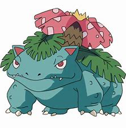

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [3]:
pokemon_types = ('venusaur', 'charizard', 'blastoise', 'pidgeot', 'pikachu', 'raichu', 'golbat',
'kadabra', 'alakazam', 'hypno', 'tauros', 'dragonite', 'mewto', 'entei', 'gengar', 'greninja', 'gyarados',
                'haunter', 'ditto', 'beedrill')
len(pokemon_types)

20

In [29]:
path = Path('pokemons')

In [16]:
if not path.exists() :
    path.mkdir()
    for o in pokemon_types :
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key,f'{o} pokemon')
        download_images(dest,urls=results.attrgot('content_url'))

In [6]:
fns = get_image_files(path)
fns

(#2914) [Path('pokemons/alakazam/00000000.png'),Path('pokemons/alakazam/00000001.png'),Path('pokemons/alakazam/00000002.png'),Path('pokemons/alakazam/00000003.png'),Path('pokemons/alakazam/00000004.png'),Path('pokemons/alakazam/00000005.jpg'),Path('pokemons/alakazam/00000006.jpg'),Path('pokemons/alakazam/00000007.jpg'),Path('pokemons/alakazam/00000008.png'),Path('pokemons/alakazam/00000009.gif')...]

In [7]:
failed = verify_images(fns)
failed

(#0) []

In [37]:
pokemons = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2,seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [38]:
dls = pokemons.dataloaders(path)

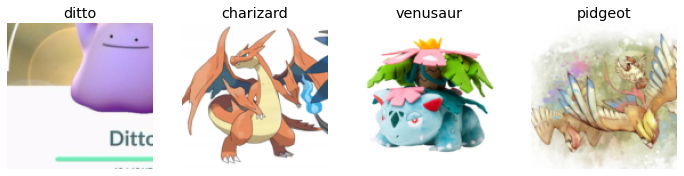

In [39]:
dls.show_batch(max_n=4,nrows=1)

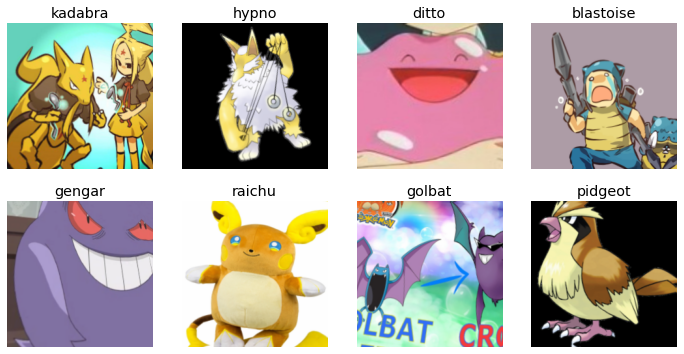

In [22]:
pokemons = pokemons.new(item_tfms=RandomResizedCrop(224,min_scale=0.5),batch_tfms=aug_transforms())
dls = pokemons.dataloaders(path)
dls.show_batch(max_n=8,nrows=2)

In [12]:
learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.136377,1.193788,0.352041,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.302594,0.858076,0.241497,00:16
1,0.984472,0.722372,0.197279,00:16
2,0.768406,0.655377,0.192177,00:16
3,0.590948,0.633227,0.183673,00:15


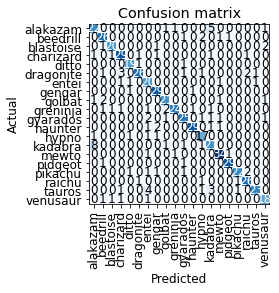

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

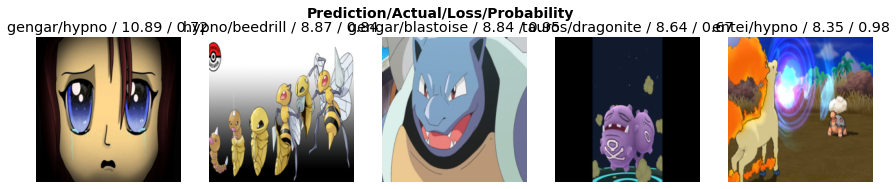

In [14]:
interp.plot_top_losses(5,nrows=1)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [16]:
for idx in cleaner.delete() : cleaner.fns[idx].unlink()
for idx,cat in cleaner.change() : shutil.move(str(cleaner.fns[idx]), path/cat)

In [23]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.017173,1.052895,0.326460,00:18


epoch,train_loss,valid_loss,error_rate,time
0,1.159169,0.693496,0.202749,00:21
1,0.861709,0.612364,0.170103,00:20
2,0.600757,0.516371,0.149485,00:20
3,0.434988,0.505387,0.134021,00:20


SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.007585775572806597)

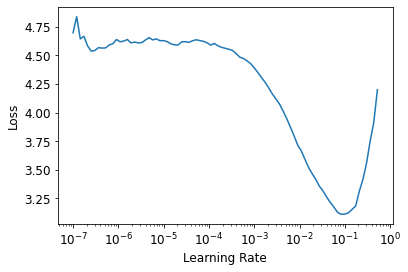

In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

In [26]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(4, 7e-3)

epoch,train_loss,valid_loss,error_rate,time
0,2.311390,1.052389,0.261168,00:18
1,1.388205,0.892644,0.235395,00:18
2,0.937696,0.619079,0.168385,00:17
3,0.654760,0.552798,0.146048,00:17


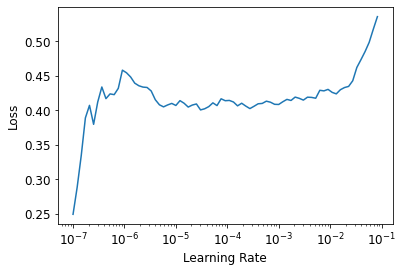

In [27]:
lr_min, lr_steep = learn.lr_find()

In [28]:
print(f"minimum/10 : {lr_min:2e}, steepest point : {lr_steep:2e}")

minimum/10 : 3.019952e-06, steepest point : 3.311311e-06


In [29]:
learn.unfreeze()

In [30]:
learn.fit_one_cycle(10, lr_max=slice(3e-6, 3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.421121,0.552580,0.147766,00:21
1,0.413814,0.539004,0.142612,00:20
2,0.397192,0.521543,0.137457,00:21
3,0.373843,0.509641,0.125430,00:20
4,0.339180,0.500087,0.127148,00:20
5,0.306849,0.503760,0.123711,00:20
6,0.291440,0.498986,0.120275,00:20
7,0.276438,0.495530,0.118557,00:24
8,0.265468,0.496263,0.116838,00:21
9,0.265141,0.495762,0.128866,00:20


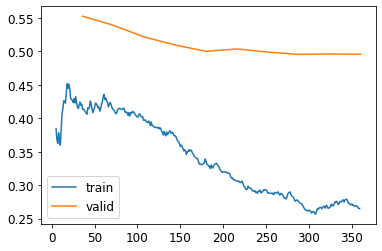

In [32]:
learn.recorder.plot_loss()

In [33]:
learn.export()

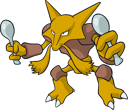

In [41]:
sample_img_path = (path/'alakazam').ls()[1]
sample_img = Image.open(sample_img_path)
sample_img = sample_img.to_thumb(128,128)
sample_img

In [4]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [5]:
learn_inf = load_learner(path/'export.pkl')

In [6]:
path = Path('pokemons')

In [7]:
learn_inf.predict((path/'alakazam').ls()[1])

('alakazam',
 tensor(0),
 tensor([9.3568e-01, 1.6984e-07, 5.2025e-09, 2.1274e-07, 2.3312e-08, 7.3564e-08, 1.7570e-07, 3.3384e-08, 2.9021e-09, 2.4218e-08, 1.0440e-08, 3.6902e-07, 1.3439e-03, 6.2969e-02, 5.1394e-08, 2.1011e-07,
         9.8308e-08, 3.9702e-07, 9.3722e-07, 8.0770e-08]))

In [8]:
learn_inf.dls.vocab

(#20) ['alakazam','beedrill','blastoise','charizard','ditto','dragonite','entei','gengar','golbat','greninja'...]

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [20]:
img = PILImage.create(btn_upload.data[-1])

In [22]:
out_pl = widgets.Output()
out_pl.clear_output() 
with out_pl : display(img.to_thumb(128,128))
out_pl

Output()

In [24]:
pred,pred_idx,probs = learn_inf.predict(img)

In [25]:
pred_lb = widgets.Label()
pred_lb.value = f'Prediction : {pred}; Probability : {probs[pred_idx]:.04f}'
pred_lb

Label(value='Prediction : pikachu; Probability : 0.9999')

In [26]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_event(change) :
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl : display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    pred_lb.value = f'Prediction : {pred}; Probabilty : {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_event)

In [38]:
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select Your Pokemon'),
     btn_upload,btn_run,out_pl,pred_lb])